# Generative Models with PyTorch — **Student Version** (MNIST)
Autoencoder → VAE (conv) → CVAE (conv)

**Read this first**
- Follow the **consignes** before each code cell marked `# TODO:`.
- Only edit where a `# TODO:` appears. Everywhere else, just run.
- When we say "**use my architecture**", we mean the conv backbone defined in the instructions here.

**Latent sizes**
- First tiny loop: latent_dim=16
- LR/L1-vs-L2 experiments: latent_dim=32
- Rest (AE/VAE/CVAE): latent_dim=64


## 0) Setup

Just run these cells. If you don't have `scikit-learn`, install it with:

```
pip install scikit-learn
```


In [1]:
import os, math, random, numpy as np
from pathlib import Path
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision, torchvision.transforms as T
import matplotlib.pyplot as plt

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)


def denorm(x):
    return x  # images are 0..1 in this version


def show_grid(imgs, nrow=8, title=None):
    import torchvision

    grid = torchvision.utils.make_grid(imgs, nrow=nrow)
    plt.figure(figsize=(min(12, nrow + 4), 4))
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

/home/lamsade/averine/miniconda3/envs/edm/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lamsade/averine/miniconda3/envs/edm/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device: cuda


## 1) DataLoader (MNIST)

**Consignes**
1. Run the next cell to load MNIST.
2. Observe tensor shapes:
   - One image: `[1, 28, 28]`
   - Batch: `[B, 1, 28, 28]`
3. Plot a small grid to visually confirm the data.


Batch images: torch.Size([64, 1, 28, 28])
Batch labels: torch.Size([64])


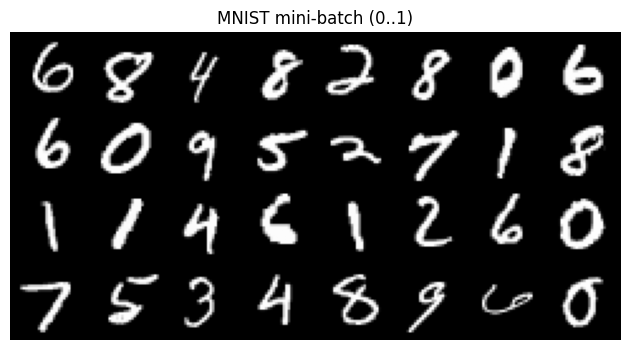

In [2]:
DATA_DIR = "./data"
BATCH_SIZE = 64

transform = T.Compose(
    [
        T.ToTensor(),  # keep in [0,1]
    ]
)

train_ds = torchvision.datasets.MNIST(
    DATA_DIR, train=True, download=True, transform=transform
)
test_ds = torchvision.datasets.MNIST(
    DATA_DIR, train=False, download=True, transform=transform
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

xb, yb = next(iter(train_loader))
print("Batch images:", xb.shape)  # [B, 1, 28, 28]
print("Batch labels:", yb.shape)  # [B]
show_grid(xb[:32], nrow=8, title="MNIST mini-batch (0..1)")

## 2) One consistent training loop

We will reuse the same training utilities for **all models**.  
You will **implement the core steps in the training loop**.

**Consignes (implement inside `train_one_epoch_steps`)**
- Put the model in train mode.
- For each batch:
  1. Move tensors to `device`.
  2. Compute `loss, metrics = loss_fn(model, (x, y))`.
  3. **Zero grads**, **backward**, **optimizer step**.
  4. Log `'loss'` and any values from `metrics`.
- Return a list of dicts (per-step metrics).

`evaluate_epoch` is provided and should not be modified.


In [ ]:
from collections import defaultdict


def train_one_epoch_steps(model, loader, optimizer, loss_fn):
    model.train()
    step_metrics = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        loss, metrics = loss_fn(model, (x, y))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        row = {"loss": float(loss.item())}
        for k, v in metrics.items():
            row[k] = float(v) if torch.is_tensor(v) else float(v)
        step_metrics.append(row)
    return step_metrics


@torch.no_grad()
def evaluate_epoch(model, loader, loss_fn):
    model.eval()
    meter = defaultdict(float)
    n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        loss, metrics = loss_fn(model, (x, y))
        meter["loss"] += float(loss.item())
        for k, v in metrics.items():
            meter[k] += float(v) if torch.is_tensor(v) else float(v)
        n += 1
    for k in meter:
        meter[k] /= max(n, 1)
    return dict(meter)


def fit(model, train_loader, val_loader, optimizer, loss_fn, epochs=5, ckpt_path=None):
    history = {"train_steps": [], "val_epoch": []}
    best = math.inf
    for ep in range(1, epochs + 1):
        steps = train_one_epoch_steps(model, train_loader, optimizer, loss_fn)
        val = evaluate_epoch(model, val_loader, loss_fn)
        history["train_steps"].append(steps)
        history["val_epoch"].append(val)
        if ckpt_path and val["loss"] < best:
            best = val["loss"]
            torch.save(
                {"model": model.state_dict(), "epoch": ep, "val_loss": best}, ckpt_path
            )
        print(f"Epoch {ep:02d} | val:", {k: round(v, 4) for k, v in val.items()})
    return history


def plot_trainsteps_vs_val(
    history, key="loss", title="Train (per step) vs Eval (per epoch)"
):
    plt.figure(figsize=(7, 4))
    x_step, y_step = [], []
    t = 0
    for ep, steps in enumerate(history["train_steps"], start=1):
        for s in steps:
            x_step.append(t)
            y_step.append(s.get(key, np.nan))
            t += 1
        x_step.append(t)
        y_step.append(np.nan)
        t += 1  # gap
    plt.plot(x_step, y_step, label=f"train/{key}")
    y_val = [v.get(key, np.nan) for v in history["val_epoch"]]
    x_val = len(x_step) / ep * np.arange(1, ep + 1) - 1
    plt.scatter(
        x_val, y_val, marker="o", label=f"val/{key}", color="orange", zorder=100
    )
    plt.xlabel("training steps (gaps per epoch)")
    plt.ylabel(key)
    plt.title(title)
    plt.legend()
    plt.show()

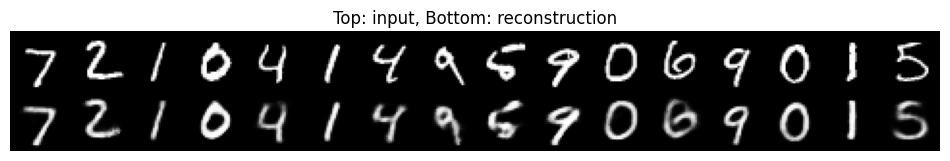

In [ ]:
# Visualize reconstructions
@torch.no_grad()
def show_recon(model, loader, n=16, title="Top: input, Bottom: reconstruction"):
    model.eval()
    x, _ = next(iter(loader))
    x = x.to(device)[:n]
    x_hat, _ = model(x)
    show_grid(torch.cat([x, x_hat], dim=0), nrow=n, title=title)

## 3) Autoencoders

### 3.1 Linear AE (learn `nn.Module` anatomy)

**Architecture**  
Encoder: Flatten → Linear(784→256) → ReLU → Linear(256→latent)  
Decoder: Linear(latent→256) → ReLU → Linear(256→784) → Sigmoid

**Consignes**
- In `__init__`, **implement both encoder and decoder** using `nn.Sequential`.
- Use **latent_dim=16**.
- Loss is **MSE**; we provide helper code.


In [17]:
class LinearAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Flatten(), nn.Linear(28 * 28, 256), nn.ReLU(), nn.Linear(256, latent_dim)
        )
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(), nn.Linear(256, 28 * 28), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z).view(-1, 1, 28, 28)
        return x_hat, z


lin_ae = LinearAE(latent_dim=16).to(device)
mse = nn.MSELoss()


def lin_ae_loss_fn(model, batch):
    x, y = batch
    x_hat, z = model(x)
    recon = mse(x_hat, x)
    return recon, {"recon": recon}

**Train the Linear AE**  
Just run the following cell **after** you implemented `LinearAE`. It uses the generic trainer you completed.


Epoch 01 | val: {'loss': 0.2291, 'recon': 0.2291}
Epoch 02 | val: {'loss': 0.2272, 'recon': 0.2272}
Epoch 03 | val: {'loss': 0.2247, 'recon': 0.2247}


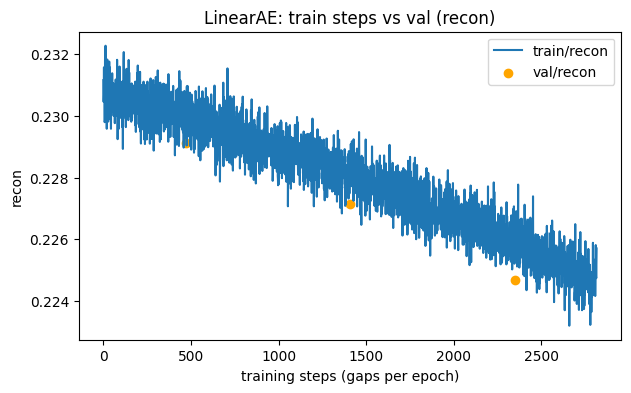

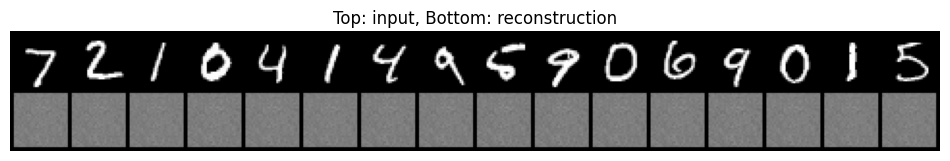

In [31]:
lin_ae = LinearAE(latent_dim=16).to(device)
opt = optim.SGD(lin_ae.parameters(), lr=1e-2)
hist_lin = fit(
    lin_ae,
    train_loader,
    test_loader,
    opt,
    lin_ae_loss_fn,
    epochs=3,
    ckpt_path="best_linearAE.pt",
)
plot_trainsteps_vs_val(
    hist_lin, key="recon", title="LinearAE: train steps vs val (recon)"
)
show_recon(lin_ae, test_loader, n=16)

Epoch 01 | val: {'loss': 0.0723, 'recon': 0.0723}
Epoch 02 | val: {'loss': 0.0699, 'recon': 0.0699}
Epoch 03 | val: {'loss': 0.0693, 'recon': 0.0693}


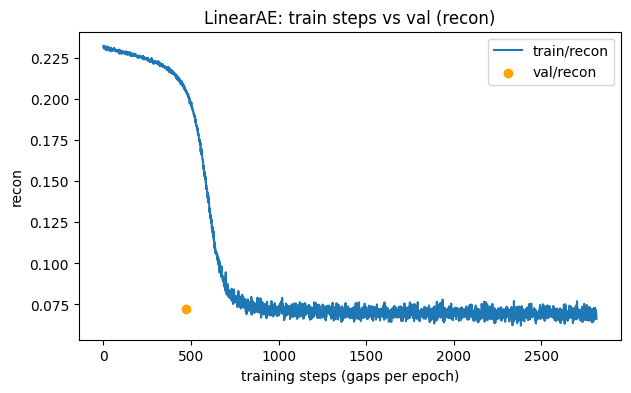

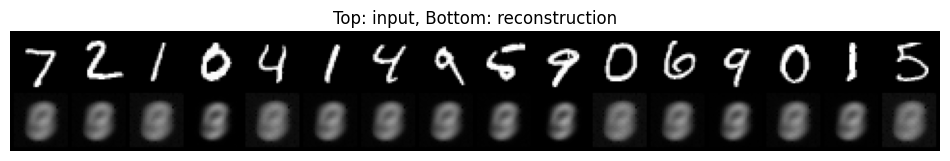

In [34]:
lin_ae = LinearAE(latent_dim=16).to(device)
opt = optim.SGD(lin_ae.parameters(), lr=1e-1)
hist_lin = fit(
    lin_ae,
    train_loader,
    test_loader,
    opt,
    lin_ae_loss_fn,
    epochs=3,
    ckpt_path="best_linearAE.pt",
)
plot_trainsteps_vs_val(
    hist_lin, key="recon", title="LinearAE: train steps vs val (recon)"
)
show_recon(lin_ae, test_loader, n=16)

Epoch 01 | val: {'loss': 0.0395, 'recon': 0.0395}
Epoch 02 | val: {'loss': 0.0283, 'recon': 0.0283}
Epoch 03 | val: {'loss': 0.0232, 'recon': 0.0232}


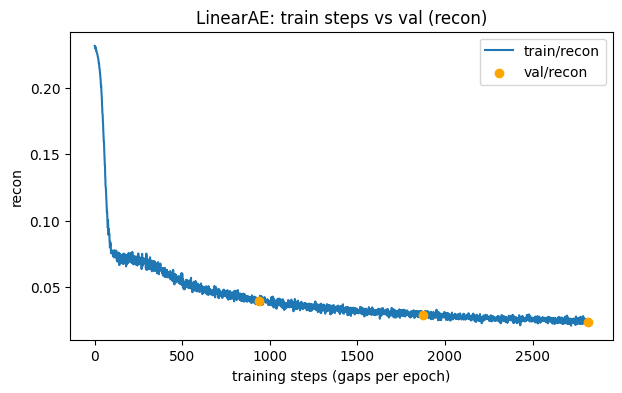

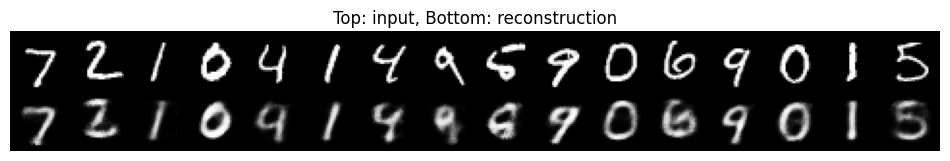

In [39]:
lin_ae = LinearAE(latent_dim=16).to(device)
opt = optim.Adam(lin_ae.parameters(), lr=1e-4)
hist_lin = fit(
    lin_ae,
    train_loader,
    test_loader,
    opt,
    lin_ae_loss_fn,
    epochs=3,
    ckpt_path="best_linearAE.pt",
)
plot_trainsteps_vs_val(
    hist_lin, key="recon", title="LinearAE: train steps vs val (recon)"
)
show_recon(lin_ae, test_loader, n=16)

### 3.2 Conv Autoencoder (use the prescribed conv architecture)

**Encoder**  
`Conv(1→32, 4,2,1)` → ReLU → `Conv(32→64, 4,2,1)` → ReLU → **Flatten** → `Linear(64·7·7→latent)`  

**Decoder**  
`Linear(latent→64·7·7)` → reshape `[B,64,7,7]` → `ConvTranspose(64→32, 4,2,1)` → ReLU → `ConvTranspose(32→1, 4,2,1)` → Sigmoid

**Consignes**
- Implement encoder/decoder in `__init__` using `nn.Sequential` + `nn.Linear`.
- Use **latent_dim=64** here and later.


In [7]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
        )
        self.fc = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        h = self.features(x).view(x.size(0), -1)
        return self.fc(h)


class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        h = self.fc(z).view(-1, 64, 7, 7)
        return self.deconv(h)


class ConvAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.enc = ConvEncoder(latent_dim)
        self.dec = ConvDecoder(latent_dim)

    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat, z


ae = ConvAE(latent_dim=64).to(device)


def ae_loss_fn(model, batch):
    x, y = batch
    x_hat, z = model(x)
    recon = mse(x_hat, x)
    return recon, {"recon": recon}

**Train the Conv AE**

Epoch 01 | val: {'loss': 0.0038, 'recon': 0.0038}
Epoch 02 | val: {'loss': 0.0027, 'recon': 0.0027}
Epoch 03 | val: {'loss': 0.0023, 'recon': 0.0023}
Epoch 04 | val: {'loss': 0.0021, 'recon': 0.0021}
Epoch 05 | val: {'loss': 0.002, 'recon': 0.002}


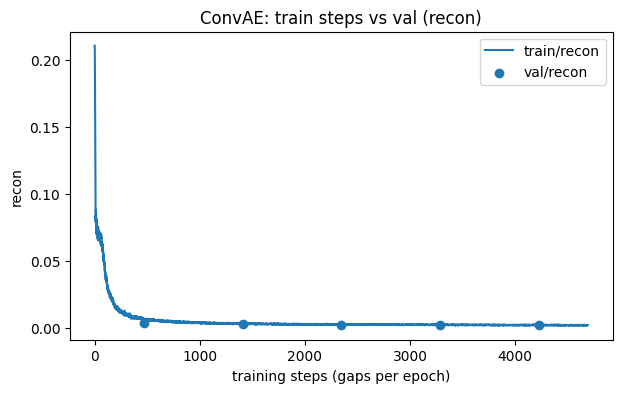

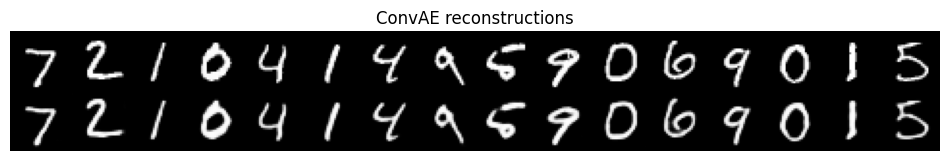

In [8]:
opt = optim.Adam(ae.parameters(), lr=1e-3)
hist_ae = fit(
    ae, train_loader, test_loader, opt, ae_loss_fn, epochs=5, ckpt_path="best_convae.pt"
)
plot_trainsteps_vs_val(hist_ae, key="recon", title="ConvAE: train steps vs val (recon)")
show_recon(ae, test_loader, n=16, title="ConvAE reconstructions")

### 3.3 Experiments: LR / optimizer / L1 vs L2

**Consignes**
- Copy the Conv AE but with **latent_dim=32**.
- Implement **L1 loss** by creating `nn.L1Loss()` and using it in the loss function.
- Try at least two learning rates (e.g., `1e-3`, `3e-4`) and compare curves.
- Optional: try `SGD` vs `Adam/AdamW`.

Summarize your observations (2–3 bullet points) in a short Markdown cell after training.


Epoch 01 | val: {'loss': 0.1332, 'recon': 0.1332}
Epoch 02 | val: {'loss': 0.1331, 'recon': 0.1331}
Epoch 03 | val: {'loss': 0.1331, 'recon': 0.1331}


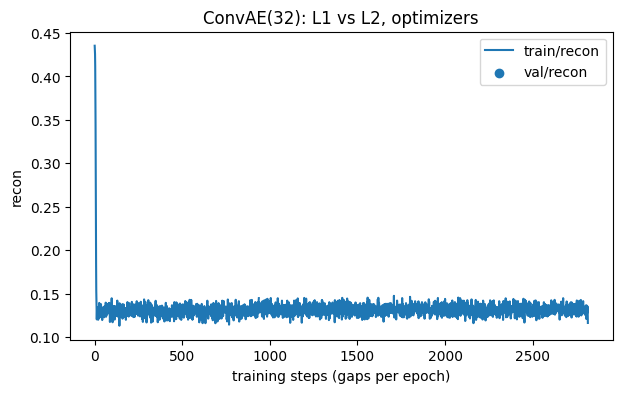

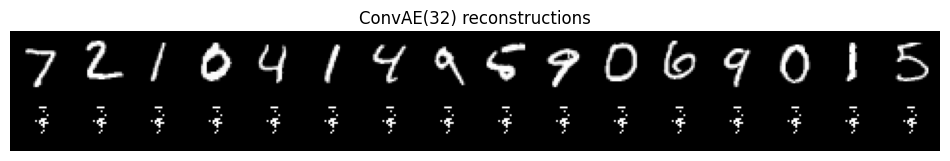

In [9]:
ae32 = ConvAE(latent_dim=32).to(device)
l1 = nn.L1Loss()


def ae32_loss_fn(model, batch):
    x, y = batch
    x_hat, z = model(x)
    recon = l1(x_hat, x)
    return recon, {"recon": recon}


opt32 = optim.Adam(ae32.parameters(), lr=1e-3)
hist_ae32 = fit(ae32, train_loader, test_loader, opt32, ae32_loss_fn, epochs=3)
plot_trainsteps_vs_val(hist_ae32, key="recon", title="ConvAE(32): L1 vs L2, optimizers")
show_recon(ae32, test_loader, n=16, title="ConvAE(32) reconstructions")

## 4) Latent size exploration

**Consignes**
- Train a **latent_dim=2** Conv AE and plot a scatter of the 2D codes for a test batch.
- Color points by digit label (different color per label).
- Train a **latent_dim=64** Conv AE and run t‑SNE on a subset of test latents.

> Expect the AE 2D latent to be **not very separable** — that’s normal.


Epoch 01 | val: {'loss': 0.0505, 'recon': 0.0505}
Epoch 02 | val: {'loss': 0.0475, 'recon': 0.0475}
Epoch 03 | val: {'loss': 0.0458, 'recon': 0.0458}
Epoch 04 | val: {'loss': 0.0451, 'recon': 0.0451}


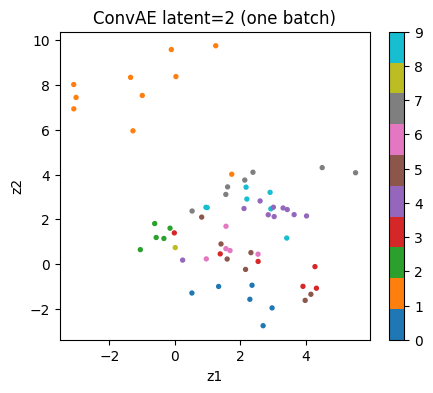

In [10]:
# 2D latent AE
ae2d = ConvAE(latent_dim=2).to(device)
opt2d = optim.Adam(ae2d.parameters(), lr=1e-3)
_ = fit(ae2d, train_loader, test_loader, opt2d, ae_loss_fn, epochs=4)

with torch.no_grad():
    x, y = next(iter(test_loader))
    Z = ae2d.enc(x.to(device)).cpu().numpy()
    Y = y.numpy()

plt.figure(figsize=(5, 4))
plt.scatter(Z[:, 0], Z[:, 1], c=Y, cmap="tab10", s=8)
plt.colorbar()
plt.title("ConvAE latent=2 (one batch)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

Epoch 01 | val: {'loss': 0.0039, 'recon': 0.0039}
Epoch 02 | val: {'loss': 0.0027, 'recon': 0.0027}
Epoch 03 | val: {'loss': 0.0024, 'recon': 0.0024}
Epoch 04 | val: {'loss': 0.0022, 'recon': 0.0022}


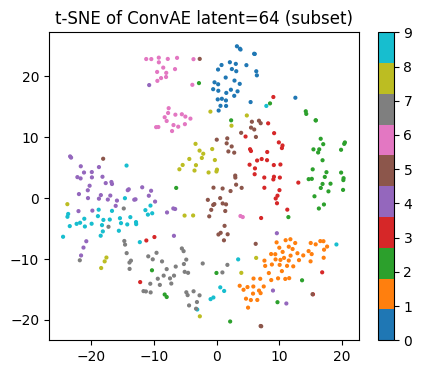

In [11]:
# t‑SNE on latent=64
try:
    from sklearn.manifold import TSNE

    have_tsne = True
except Exception as e:
    print("Install scikit-learn for TSNE:", e)
    have_tsne = False

ae64 = ConvAE(latent_dim=64).to(device)
opt64 = optim.Adam(ae64.parameters(), lr=1e-3)
_ = fit(ae64, train_loader, test_loader, opt64, ae_loss_fn, epochs=4)

Zs, Ys = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        if i >= 6:
            break
        Zs.append(ae64.enc(x.to(device)).cpu().numpy())
        Ys.append(y.numpy())
Z = np.concatenate(Zs)
Y = np.concatenate(Ys)

if have_tsne:
    Z2 = TSNE(
        n_components=2, init="random", perplexity=30, learning_rate="auto"
    ).fit_transform(Z)
    plt.figure(figsize=(5, 4))
    plt.scatter(Z2[:, 0], Z2[:, 1], c=Y, cmap="tab10", s=4)
    plt.colorbar()
    plt.title("t‑SNE of ConvAE latent=64 (subset)")
    plt.show()

## 5) VAE (conv): Gaussian latent with MSE + KL

**Objective (we minimize its value):**
$$
\mathcal{L}(x) \;=\; \mathrm{MSE}(x,\hat x) \;+\; \beta \cdot \mathrm{KL}\big(q_\phi(z|x)\,\|\,\mathcal{N}(0,I)\big).
$$

**Consignes**
- Implement in `__init__` the **same conv encoder/decoder** as Conv AE (decoder ends with **Sigmoid**).
- Implement the **reparameterization trick**:
  $$z = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0,I)$$
- Implement the **KL term**:
  $$\mathrm{KL} = -\\tfrac{1}{2} \; \mathbb{E}\\left[1 + \log\\sigma^2 - \mu^2 - \sigma^2\\right]$$
- Use **MSE** for the reconstruction term; set `beta=1.0`.


In [40]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.enc_feat = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
        )
        self.enc_fc = nn.Linear(64 * 7 * 7, 128)
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        self.dec_fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.enc_feat(x).view(x.size(0), -1)
        h = torch.relu(self.enc_fc(h))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = self.dec_fc(z).view(-1, 64, 7, 7)
        return self.dec_deconv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, (mu, logvar, z)


def vae_loss_fn(beta=1.0):
    def _fn(model, batch):
        x, y = batch
        x_hat, (mu, logvar, z) = model(x)
        recon = mse(x_hat, x)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta * kl
        return loss, {"recon": recon, "kl": kl}

    return _fn

**Train VAE**

Epoch 01 | val: {'loss': 0.037, 'recon': 0.025, 'kl': 0.2402}
Epoch 02 | val: {'loss': 0.0335, 'recon': 0.0205, 'kl': 0.2593}
Epoch 03 | val: {'loss': 0.0324, 'recon': 0.0186, 'kl': 0.2752}
Epoch 04 | val: {'loss': 0.0317, 'recon': 0.018, 'kl': 0.2743}
Epoch 05 | val: {'loss': 0.0314, 'recon': 0.0181, 'kl': 0.265}


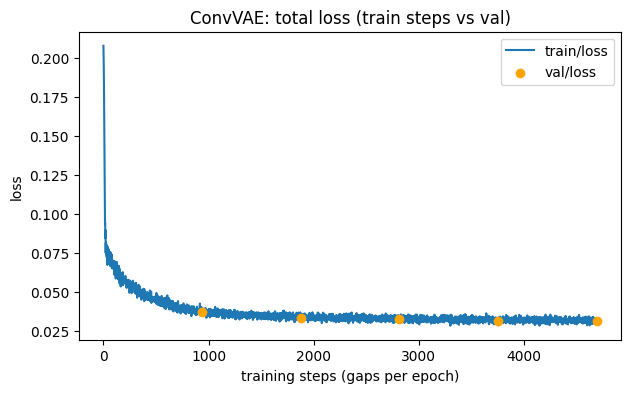

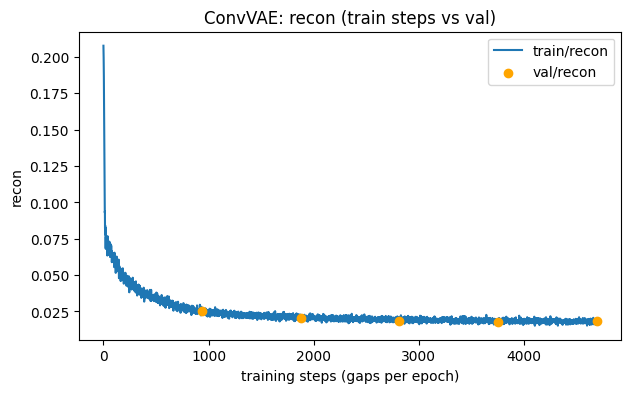

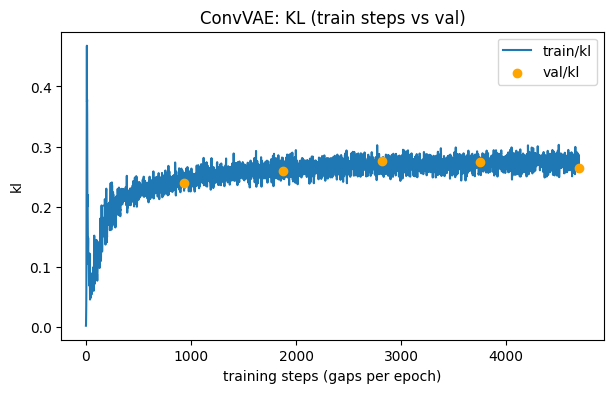

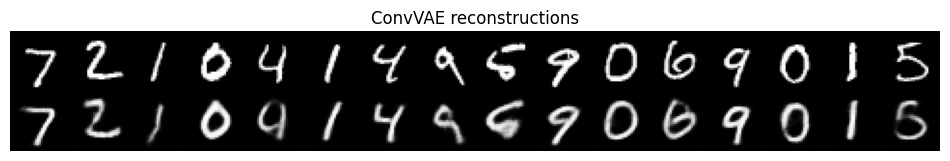

In [46]:
vae = ConvVAE(latent_dim=64).to(device)
opt_vae = optim.Adam(vae.parameters(), lr=1e-3)
hist_vae = fit(
    vae,
    train_loader,
    test_loader,
    opt_vae,
    vae_loss_fn(beta=0.05),
    epochs=5,
    ckpt_path="best_convvae.pt",
)
plot_trainsteps_vs_val(
    hist_vae, key="loss", title="ConvVAE: total loss (train steps vs val)"
)
plot_trainsteps_vs_val(
    hist_vae, key="recon", title="ConvVAE: recon (train steps vs val)"
)
plot_trainsteps_vs_val(hist_vae, key="kl", title="ConvVAE: KL (train steps vs val)")
show_recon(vae, test_loader, n=16, title="ConvVAE reconstructions")

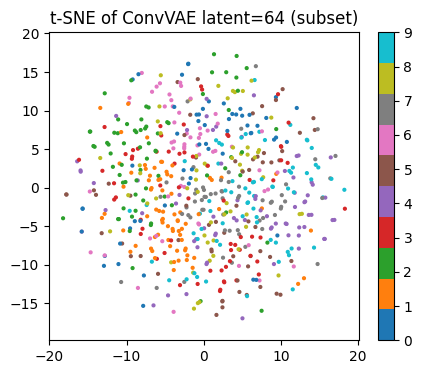

In [47]:
# t-SNE on VAE latent=64 (already trained)


Zs, Ys = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        if i >= 10:
            break
        mu, logvar = vae.encode(x.to(device))
        Zs.append(vae.reparameterize(mu, logvar).cpu().numpy())
        Ys.append(y.numpy())
Z = np.concatenate(Zs)
Y = np.concatenate(Ys)

if have_tsne:
    Z2 = TSNE(
        n_components=2, init="random", perplexity=30, learning_rate="auto"
    ).fit_transform(Z)
    plt.figure(figsize=(5, 4))
    plt.scatter(Z2[:, 0], Z2[:, 1], c=Y, cmap="tab10", s=4)
    plt.colorbar()
    plt.axis("equal")
    plt.title("t‑SNE of ConvVAE latent=64 (subset)")
    plt.show()

### 5.1 Sampling & interpolation

**Consignes**
- Implement `sample_vae(model, n, latent_dim)`:
  1. Sample `z ~ N(0, I)`
  2. Decode to images in `[0,1]`
- Implement `interpolate_vae(model, xA, xB, steps)`:
  1. Encode `xA, xB` → `muA, logvarA`, `muB, logvarB`
  2. Reparameterize to `zA, zB`
  3. Linearly interpolate between `zA` and `zB`
  4. Decode all points


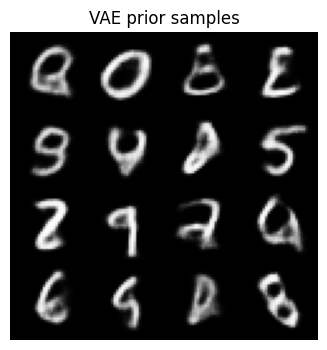

In [48]:
@torch.no_grad()
def sample_vae(model, n=16, latent_dim=64):
    model.eval()
    z = torch.randn(n, latent_dim, device=device)
    return model.decode(z)


samples = sample_vae(vae, n=16, latent_dim=64)
show_grid(samples, nrow=4, title="VAE prior samples")

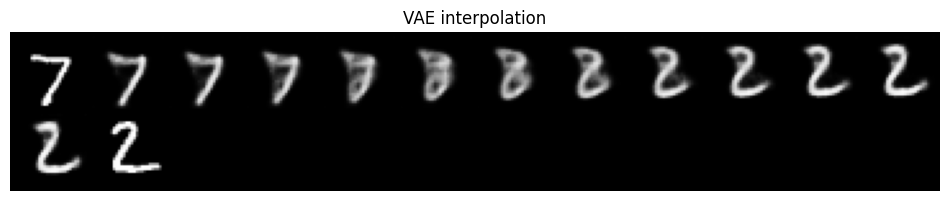

In [49]:
@torch.no_grad()
def interpolate_vae(model, xA, xB, steps=9):
    model.eval()
    muA, logvarA = model.encode(xA)
    zA = model.reparameterize(muA, logvarA)
    muB, logvarB = model.encode(xB)
    zB = model.reparameterize(muB, logvarB)
    alphas = torch.linspace(0, 1, steps, device=device).view(-1, 1)
    Z = (1 - alphas) * zA + alphas * zB
    return model.decode(Z)


xb, _ = next(iter(test_loader))
xA, xB = xb[:1].to(device), xb[1:2].to(device)
interp_imgs = interpolate_vae(vae, xA, xB, steps=12)
show_grid(torch.cat([xA, interp_imgs, xB], 0), nrow=12, title="VAE interpolation")

## 6) Conditional VAE (CVAE)

We condition on the class label $y$ by concatenating a learned one‑hot embedding to $z$ before decoding:
$$
\text{decoder input} = [z;\; e(y)].
$$

**Consignes**
- Reuse the same encoder as VAE (same convs and FCs).
- Add a small linear layer to embed one‑hot labels to size `emb_dim` (e.g., 16).
- In the decoder, **concatenate** `z` and `e(y)` and then decode.
- Loss is the same: **MSE + KL**.
- Implement a **class-conditional sampler** `sample_cvae(model, labels, latent_dim)`:
  - sample `z ~ N(0, I)`
  - decode with provided labels


In [50]:
def one_hot(y, num_classes=10):
    oh = torch.zeros(y.size(0), num_classes, device=y.device)
    oh.scatter_(1, y.view(-1, 1), 1.0)
    return oh


class ConvCVAE(nn.Module):
    def __init__(self, latent_dim=64, num_classes=10, emb_dim=16):
        super().__init__()
        self.num_classes = num_classes
        self.emb = nn.Linear(num_classes, emb_dim, bias=False)
        self.enc_feat = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
        )
        self.enc_fc = nn.Linear(64 * 7 * 7, 128)
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        self.dec_fc = nn.Linear(latent_dim + emb_dim, 64 * 7 * 7)
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.enc_feat(x).view(x.size(0), -1)
        h = torch.relu(self.enc_fc(h))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z, y):
        y_emb = self.emb(one_hot(y, self.num_classes))
        h = self.dec_fc(torch.cat([z, y_emb], dim=1)).view(-1, 64, 7, 7)
        return self.dec_deconv(h)

    def forward(self, x, y):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, y)
        return x_hat, mu, logvar, z


def cvae_loss_fn(beta=1.0):
    def _fn(model, batch):
        x, y = batch
        x_hat, mu, logvar, z = model(x, y)
        recon = mse(x_hat, x)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta * kl
        return loss, {"recon": recon, "kl": kl}

    return _fn

**Train CVAE**

Epoch 01 | val: {'loss': 0.0537, 'recon': 0.0529, 'kl': 0.0016}
Epoch 02 | val: {'loss': 0.0532, 'recon': 0.052, 'kl': 0.0025}
Epoch 03 | val: {'loss': 0.0529, 'recon': 0.0513, 'kl': 0.0032}
Epoch 04 | val: {'loss': 0.0527, 'recon': 0.0508, 'kl': 0.0038}


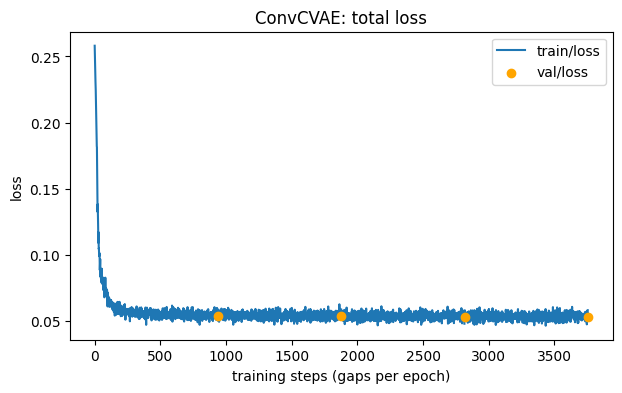

In [ ]:
cvae = ConvCVAE(latent_dim=64).to(device)
opt_cvae = optim.Adam(cvae.parameters(), lr=1e-3)
hist_cvae = fit(
    cvae,
    train_loader,
    test_loader,
    opt_cvae,
    cvae_loss_fn(beta=0.1),
    epochs=4,
    ckpt_path="best_convcvae.pt",
)
plot_trainsteps_vs_val(hist_cvae, key="loss", title="ConvCVAE: total loss")

**Class-conditional sampling**

**Consignes**
- Implement `sample_cvae(model, labels, latent_dim)`:
  1. Labels is a CPU LongTensor (length = n).
  2. Move labels to device, sample `z ~ N(0,I)` of shape `[n, latent_dim]`.
  3. Decode with `(z, labels)`.


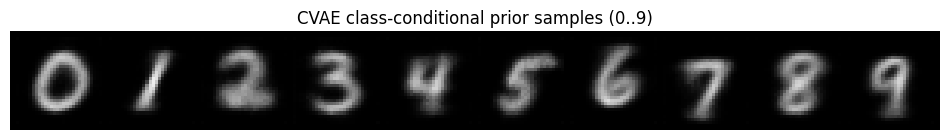

In [55]:
@torch.no_grad()
def sample_cvae(model, labels, latent_dim=64):
    model.eval()
    y = labels.to(device)
    z = torch.randn(len(labels), latent_dim, device=device)
    return model.decode(z, y)


labels = torch.arange(10)
cvae_samples = sample_cvae(cvae, labels, latent_dim=64)
show_grid(cvae_samples, nrow=10, title="CVAE class-conditional prior samples (0..9)")

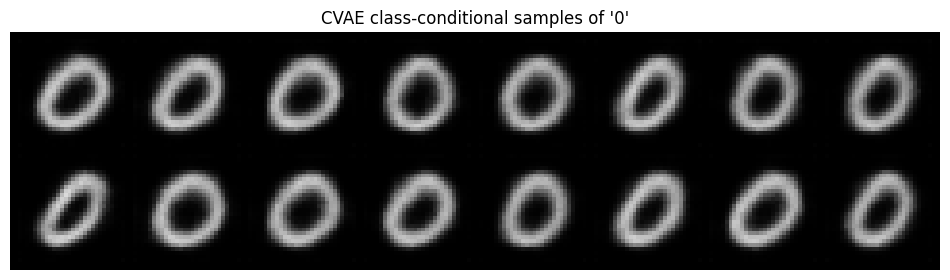

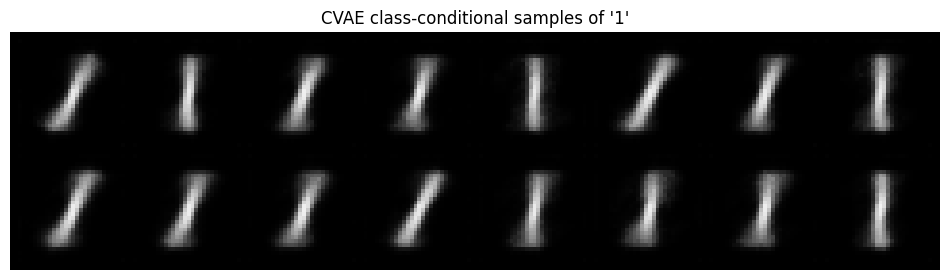

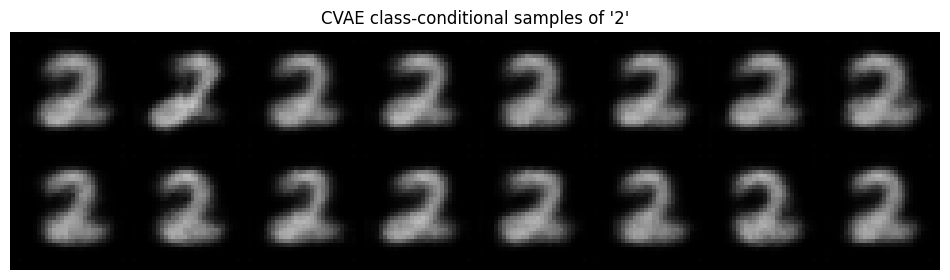

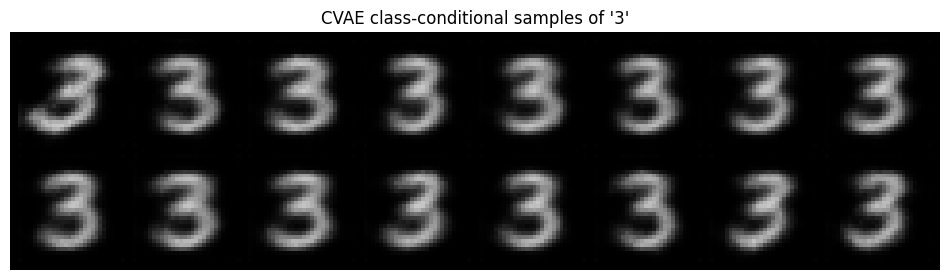

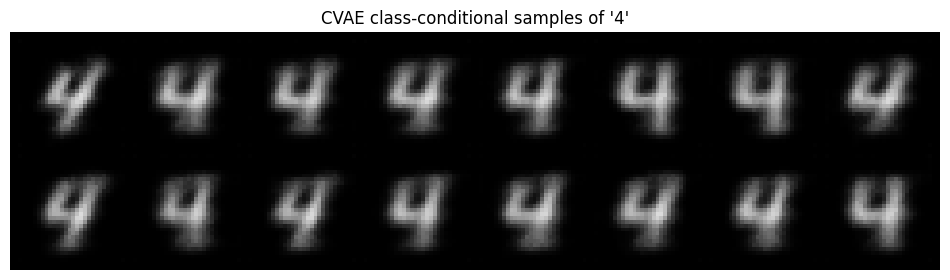

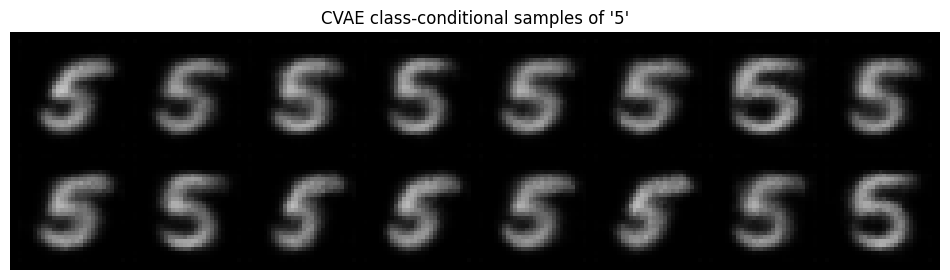

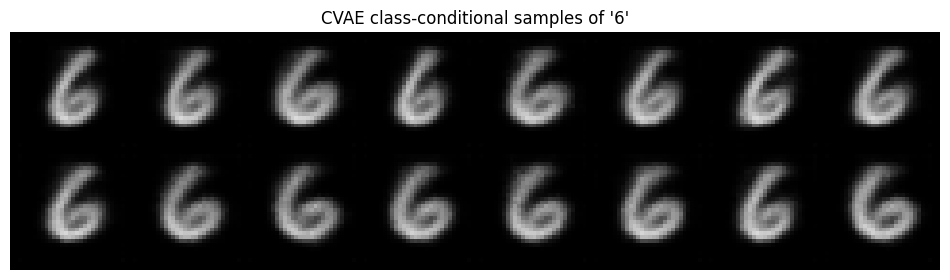

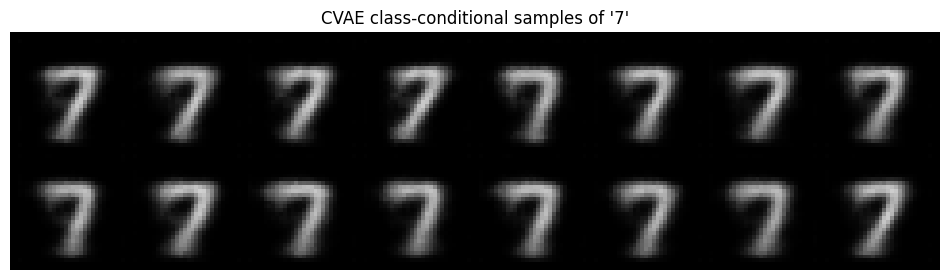

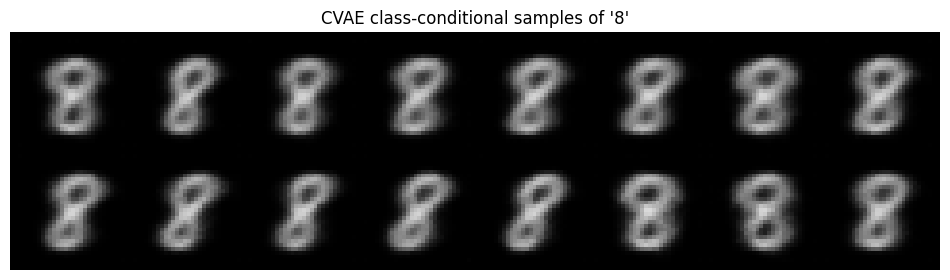

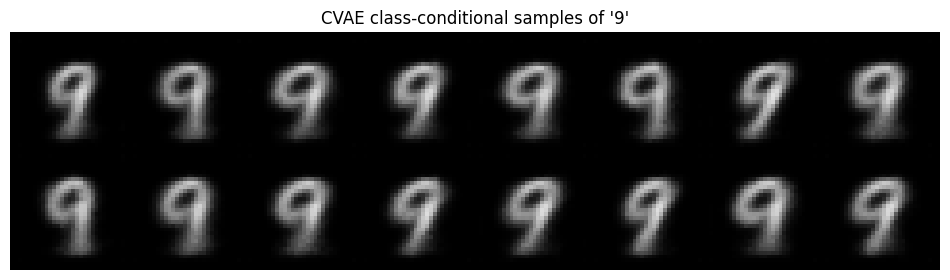

In [56]:
for label in range(10):
    samples = sample_cvae(cvae, torch.full((16,), label), latent_dim=64)
    show_grid(samples, nrow=8, title=f"CVAE class-conditional samples of '{label}'")

## 7) Wrap‑up

- You implemented: training loop core, AE/VAE/CVAE modules, VAE KL + reparam, CVAE conditioning, and samplers.
- You ran LR/L1-vs-L2 experiments and visualized latent spaces.
- Reflect: what does the VAE's KL do to the latent structure vs plain AE?
